In [524]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['diff', 'mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [449]:
max_l = 10
l_bins = int((max_l/2)+1)
n=35
m=10

## Create QPM Matrices

In [429]:
full_minmock = 1
full_maxmock = 1000
N_full = full_maxmock - full_minmock + 1

In [450]:
qpm_dir = '/mnt/store1/oliverphilcox/QPM_Full2/'
t = loadtxt(qpm_dir+'0001_corr.dat')
rr = t[:,-1]
N_bins = len(rr)
input_mu = t[:,0]
mm=len(np.unique(input_mu))
input_r = t[:,1]
nn = len(np.unique(input_r))
all_r = np.unique(input_r)
all_mu = np.unique(input_mu)
dd=t[:,-3]

In [451]:
sumW_DD = np.load('/mnt/store1/oliverphilcox/DR12_QPM/sumW_DD.npy')
mock1 = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/processed/qpm_galaxy_1.xyzwj')
sumW = np.sum(mock1[:,3])
dd_cf = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/DDcounts.dat')

In [432]:
rand1 = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/qpm_randoms_10x.xyzwj')
sumWran = np.sum(rand1[:,3])
rr_cf = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/RRcounts_n45_m10.dat')*sumWran**2.
rand_ratio=np.sqrt(np.mean(rr/rr_cf*2))

In [452]:
sumRR=sumWran*np.mean(np.sqrt((2.*rr)/(rr_cf)))

In [453]:
full_xi_qpm = zeros((N_full,N_bins))
N_gal_ratio = zeros((N_full))

for i in range(full_minmock,full_maxmock+1):
    mocknum = str(i).zfill(4)
    t = loadtxt(qpm_dir+mocknum+'_corr.dat')
    dd = t[:,-3]
    dr = t[:,-2]
    
    j = i - full_minmock
    
    this_rr = rr/sumRR**2.
    this_dr = dr/(sumRR*sumW_DD[j])
    this_dd = dd/sumW_DD[j]**2.
    
    full_xi_qpm[j] = this_dd/this_rr-this_dr/this_rr+1.

#### Define full $(r,\mu)$ QPM covariance

In [454]:
all_mocks = full_xi_qpm[:,100:] # excluding first 100 bins
n_mocks = len(all_mocks)

mean_xi = np.mean(all_mocks,axis=0)
diff = all_mocks-mean_xi
qpm_covariance_rmu = np.matmul(diff.T,diff)/(n_mocks-1.)

#### Define Legendre QPM Covariance

In [455]:
from scipy.special import legendre
all_mocks_Legendre = np.zeros([n_mocks,l_bins*n])
for r_a in range(n):
    these_bins=all_mocks[:,r_a*m:(r_a+1)*m]
    for p_i in range(l_bins):
        p_moment = 2*p_i
        all_mocks_Legendre[:,r_a*l_bins+p_i]=(2*p_moment+1)*np.sum(legendre(p_moment)(all_mu)*these_bins,axis=1)/len(all_mu)

In [456]:
mean_xi_Legendre = np.mean(all_mocks_Legendre,axis=0)
diff_Legendre = all_mocks_Legendre-mean_xi_Legendre
qpm_covariance_Legendre = np.matmul(diff_Legendre.T,diff_Legendre)/(n_mocks-1.)

#### Compare to finely binned $\xi$ estimates

In [458]:
xi_file='/mnt/store1/oliverphilcox/QPM_xiFine/QPM_mean.xi'
xi_mu = np.genfromtxt(xi_file,max_rows=1,skip_header=1)
xi_r = np.genfromtxt(xi_file,max_rows=1)
xi_all = np.loadtxt(xi_file,skiprows=2)

In [459]:
RR_r=np.genfromtxt('/mnt/store1/oliverphilcox/QPMcounts/qpm-unrecon-0001-RR.dat',max_rows=1)
RR_r=0.5*(RR_r[:-3]+RR_r[1:-2])
RR_mu=np.genfromtxt('/mnt/store1/oliverphilcox/QPMcounts/qpm-unrecon-0001-RR.dat',max_rows=1,skip_header=1)
RR_mu=0.5*(RR_mu[:-1]+RR_mu[1:])
RR_all=np.loadtxt('/mnt/store1/oliverphilcox/QPMcounts/qpm-unrecon-0001-RR.dat',skiprows=2)[:-2,:]

In [460]:
xi_leg = np.zeros([len(xi_all),l_bins])
for p in range(l_bins):
    p_moment = 2*p
    xi_leg[:,p]=(2*p_moment+1)*np.sum(legendre(p_moment)(xi_mu)*xi_all,axis=1)/len(xi_mu)

#### Create covariance matrix from finely binned $(r,\mu)$

In [461]:
all_xi_leg=[]
for mock_no in range(1,100):
    xi_file='/mnt/store1/oliverphilcox/QPM_xiFine/QPM_mock_%d.xi'%mock_no
    this_xi=np.loadtxt(xi_file,skiprows=2)
    # Rebin into wider bins
    new_xi = np.zeros([n,RR_all.shape[1]])
    for i in range(n):
        new_xi[i,:]=np.sum((RR_all[40+4*i:40+4*(i+1),:]*this_xi[40+4*i:40+4*(i+1),:]),axis=0)/np.sum(RR_all[40+4*i:40+4*(i+1),:],axis=0)
    this_xi_leg = np.zeros([len(new_xi),l_bins])
    for p in range(l_bins):
        p_moment = 2*p
        this_xi_leg[:,p]=(2*p_moment+1)*np.sum(legendre(p_moment)(xi_mu)*new_xi,axis=1)/len(xi_mu)
    all_xi_leg.append(this_xi_leg.ravel())

In [462]:
mean_xi_leg = np.mean(all_xi_leg,axis=0)
diff_leg = all_xi_leg[:]-mean_xi_leg
qpm_cov_fine_leg = np.matmul(diff_leg.T,diff_leg)/(len(diff_leg)-1)

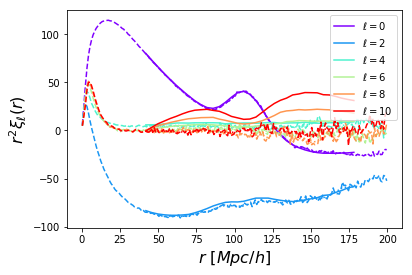

In [463]:
c=cm.rainbow(np.linspace(0,1,l_bins))
for i in range(l_bins):
    plt.plot(all_r[10:],all_r[10:]**2.*all_mocks_Legendre[:,i::6].mean(axis=0),label=r'$\ell = %d$'%(i*2),c=c[i])
    plt.plot(all_r[10:],all_r[10:]**2.*np.asarray(all_xi_leg)[:,i::6].mean(axis=0),c=c[i],ls=':')
    plt.plot(xi_r,xi_r**2.*xi_leg[:,i],c=c[i],ls='--')
plt.ylabel(r'$r^2 \xi_\ell(r)$',fontsize=16);plt.xlabel(r'$r\,\, [Mpc/h]$',fontsize=16);plt.legend();

In [464]:
def rebinner(in_matrix):
    out_matrix = np.zeros_like(in_matrix)
    for r_a in range(n):
        for r_b in range(n):
            for p_i in range(l_bins):
                for q_i in range(l_bins):
                    out_matrix[p_i*n+r_a,q_i*n+r_b]=in_matrix[r_a*l_bins+p_i,r_b*l_bins+q_i]
    return out_matrix

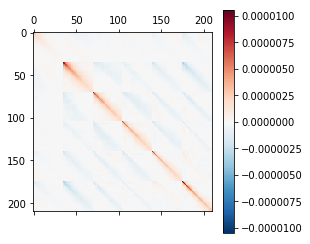

In [465]:
mat=rebinner(qpm_covariance_Legendre)
vmax=max(mat.ravel())
plt.matshow(rebinner(qpm_covariance_Legendre),vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

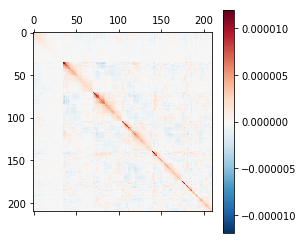

In [466]:
mat=rebinner(qpm_cov_fine_leg)
vmax=max(mat.ravel())
plt.matshow(rebinner(qpm_cov_fine_leg),vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

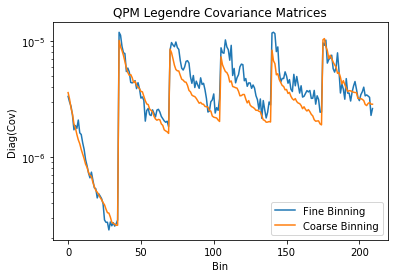

In [467]:
plt.plot(np.diag(rebinner(qpm_cov_fine_leg)),label='Fine Binning')
plt.plot(np.diag(rebinner(qpm_covariance_Legendre)),label='Coarse Binning')
plt.yscale('log');plt.legend();
plt.xlabel('Bin')
plt.ylabel('Diag(Cov)');
plt.title('QPM Legendre Covariance Matrices');

#### Invert Matrices via Hartlap rescaling

In [559]:
D_Hartlap_fine = 1 - (len(qpm_cov_fine_leg)+1)/(len(diff_leg)-1)
D_Hartlap_coarse = 1 - (len(qpm_covariance_Legendre)+1)/(len(diff_Legendre)-1)
qpm_prec_fine = D_Hartlap_fine*np.linalg.inv(qpm_cov_fine_leg)
qpm_prec_coarse = D_Hartlap_coarse*np.linalg.inv(qpm_covariance_Legendre)

## Load Computed Matrices

#### Load $(r,\mu)$ and Legendre matrices

In [468]:
work_dir = '/mnt/store1/oliverphilcox/Legendre2PCF/MeanXi/CovMatricesAll/'

In [525]:
c2l = np.loadtxt(work_dir+'c2_leg_n35_l10_11_full.txt')
c3l = np.loadtxt(work_dir+'c3_leg_n35_l10_1,11_full.txt')
c4l = np.loadtxt(work_dir+'c4_leg_n35_l10_11,11_full.txt')

In [551]:
leg_full = np.load('/mnt/store1/oliverphilcox/Legendre2PCF/Rescaled_Covariance_Matrices_n35_l10.npz')

In [554]:
leg_prec=leg_full.f.precision

In [526]:
rascal_m=30
c2f = np.diag(np.loadtxt(work_dir+'c2_n%d_m%d_11_full.txt'%(n,rascal_m)))
c3f = np.loadtxt(work_dir+'c3_n%d_m%d_1,11_full.txt'%(n,rascal_m))
c4f = np.loadtxt(work_dir+'c4_n%d_m%d_11,11_full.txt'%(n,rascal_m))

In [527]:
cl_tot = c2l+c3l+c4l
cf_tot = c2f+c3f+c4f

#### Find Legendre approximation from $(r,\mu)$ matrix

In [528]:
from scipy.special import legendre
mu_cen = np.arange(0+1./(2.*rascal_m),1+1./(2.*rascal_m),1./rascal_m)

In [529]:
cf_legendre = np.zeros_like(cl_tot)
for p_i in range(l_bins):
    legendre_p = p_i*2
    for q_i in range(l_bins):
        legendre_q = q_i*2
        all_factors = np.matmul(legendre(legendre_p)(mu_cen).reshape(-1,1),legendre(legendre_q)(mu_cen).reshape(1,-1))
        for r_a in range(n):
            for r_b in range(n):
                this_cov = cf_tot[rascal_m*r_a:rascal_m*(r_a+1),rascal_m*r_b:rascal_m*(r_b+1)]
                cf_legendre[r_a*l_bins+p_i,r_b*l_bins+q_i]=np.sum(all_factors*this_cov)*(1./rascal_m)**2.*(2.*legendre_p+1)*(2.*legendre_q+1)

In [530]:
ind_cov_full_legendre=[]
for i in range(l_bins):
    ind_cov_full_legendre.append(cf_legendre[i::l_bins,i::l_bins])

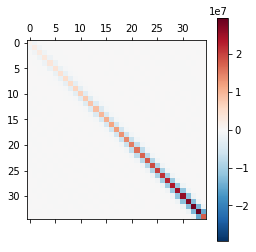

In [531]:
mat=np.linalg.inv(ind_cov_full_legendre[0])
vmax=max(mat.ravel())
plt.matshow(mat,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax);plt.colorbar();

In [532]:
ind_cov_legendre=[]
for i in range(l_bins):
    ind_cov_legendre.append(cl_tot[i::l_bins,i::l_bins])

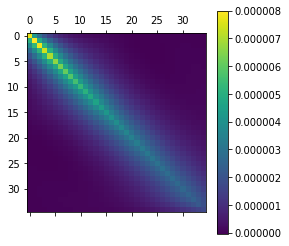

In [533]:
plt.matshow(ind_cov_legendre[2]);plt.colorbar()

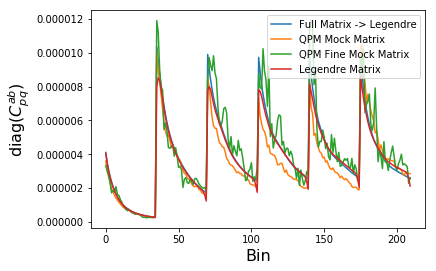

In [534]:
plt.plot(np.diag(rebinner(cf_legendre)),label='Full Matrix -> Legendre')
plt.plot(np.diag(rebinner(qpm_covariance_Legendre)),label='QPM Mock Matrix')
plt.plot(np.diag(rebinner(qpm_cov_fine_leg)),label='QPM Fine Mock Matrix')
plt.plot(np.diag(rebinner(cl_tot)),label='Legendre Matrix');
plt.legend();
plt.ylabel(r'$\mathrm{diag}(C^{ab}_{pq})$',fontsize=16);plt.xlabel(r'Bin',fontsize=16);

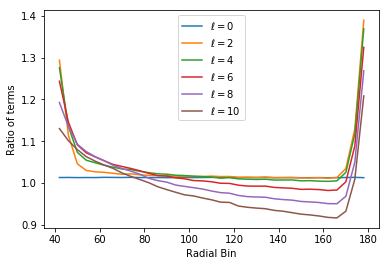

In [547]:
for i in range(6):
    plt.plot(all_r[10:],np.diag(ind_cov_full_legendre[i])/np.diag(ind_cov_legendre[i]),label=r'$\ell = %d$'%(2*i))
plt.ylabel('Ratio of terms')
plt.xlabel('Radial Bin');
plt.legend();

#### Display matrix in other ordering;

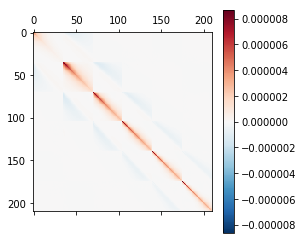

In [550]:
mat=rebinner(cl_tot)
vmax=max(mat.ravel())
plt.matshow(mat,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax);plt.colorbar();

### Check Matrix Differences

In [603]:
root_leg_prec = np.linalg.cholesky(leg_prec)
disc_qpm = rebinner(np.matmul(root_leg_prec.T,np.matmul(qpm_cov_fine_leg,root_leg_prec)))

Plot $\sqrt{\Psi_\mathrm{RascalC}}^T C_\mathrm{QPM} \sqrt{\Psi_\mathrm{RascalC}} - \mathbb{I}$ for QPM vs RascalC:

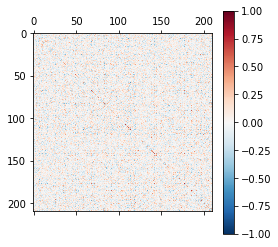

In [605]:
vmax=1
plt.matshow(disc_qpm-np.eye(len(disc_qpm)),vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();

Now plot for RascalC[Legendre] vs RascalC[$r,\mu$]:

In [607]:
root_leg_prec = np.linalg.cholesky(leg_prec)
disc_rascal = rebinner(np.matmul(root_leg_prec.T,np.matmul(cf_legendre,root_leg_prec)))

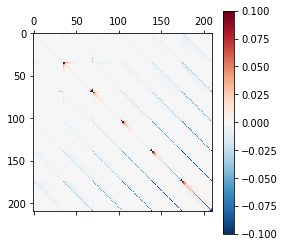

In [611]:
vmax=0.1
plt.matshow(disc_rascal-np.eye(len(disc_rascal)),vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();

In [614]:
def KL_div(prec,cov):
    logdet1 = np.linalg.slogdet(prec)
    logdet2 = np.linalg.slogdet(cov)
    if logdet1[0]<0 or logdet2[0]<0:
        return np.inf
    else:
        return 0.5*(np.trace(np.matmul(prec,cov))-logdet1[1]-logdet2[1]-len(cov))

In [667]:
def other_n_eff(prec):
    i=np.arange(len(prec))
    #r_bins=np.asarray([[all_r[j+10] for _ in range(l_bins)] for j in range(len(all_r)-10)]).ravel()
    r_bins = all_r[10:]
    filt=np.where(r_bins[i//l_bins]>142)
    filt2 = np.where(r_bins[i//l_bins]<82)
    psis=[]
    for f in filt[0]:
        for f2 in filt2[0]:
            psis.append(prec[f,f2]/np.sqrt(prec[f,f]*prec[f2,f2]))
    var=np.var(psis)
    n_bins = len(prec)
    return n_bins+1./var

In [692]:
print("Smooth Coarse QPM vs RascalC KL: %.2f"%KL_div(leg_prec,qpm_covariance_Legendre))
print("RascalC[Legendre] vs RascalC[r,mu]: %.2f"%KL_div(leg_prec,cf_legendre))
print("N_eff RascalC[Legendre]: %.2e"%other_n_eff(leg_prec))
print("N_eff RascalC[r,mu]: %.2e"%other_n_eff(np.linalg.inv(cf_legendre)))
expected_KL = len(leg_prec)*(len(leg_prec)+1)/(4.*len(diff_Legendre))
print("Expected Smooth Coarse QPM vs RascalC KL: %.2f"%expected_KL)

Smooth Coarse QPM vs RascalC KL: 40.33
RascalC[Legendre] vs RascalC[r,mu]: 0.77
N_eff RascalC[Legendre]: 3.66e+06
N_eff RascalC[r,mu]: 1.17e+06
Expected Smooth Coarse QPM vs RascalC KL: 11.08


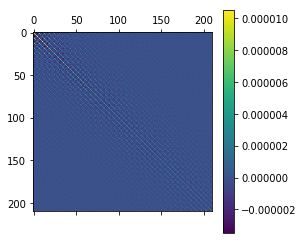

In [693]:
plt.matshow(qpm_covariance_Legendre);plt.colorbar();

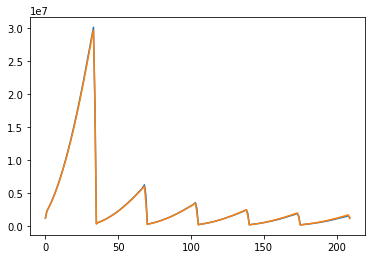

In [694]:
plt.plot(np.diag(rebinner(leg_prec)))
plt.plot(np.diag(np.linalg.inv(rebinner(cf_legendre))));
#plt.plot(np.diag((rebinner(qpm_prec_coarse))))

In [726]:
def residuals(matrix,prec=False):
    r_bins = np.loadtxt('/mnt/store1/oliverphilcox/Legendre2PCF/radial_binning_cov.csv').mean(axis=1)
    l_bins_list = np.arange(l_bins)
    
    n=len(r_bins)
    r_bins_all = np.concatenate([[r_bins[i] for _ in range(l_bins)] for i in range(len(r_bins))])
    l_bins_all = np.hstack([l_bins_list for _ in range(len(r_bins))])
    r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))
    
    if prec:
        resid=matrix/r_matrix
    else:
        resid=matrix*r_matrix
    
    r_diff = []
    for rr in r_bins:
        for rr2 in r_bins:
            r_diff.append(rr-rr2)
    r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors
    l_diff = []
    for l in l_bins_list:
        for l2 in l_bins_list:
            l_diff.append(l-l2)
    l_diff = np.unique(np.asarray(l_diff).round(8)) # remove rounding errors

    l_edge = np.linspace(-5,5,len(l_diff)+1)
    delta_r = r_diff[1]-r_diff[0]
    r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)
    l_edges = np.vstack([l_edge for _ in range(len(r_edge))])
    r_edges = np.vstack([r_edge for _ in range(len(l_edge))])

    stacked_resid = np.zeros([len(l_diff),len(r_diff)])
    denom = np.zeros([len(l_diff),len(r_diff)])
    for i in range(len(resid)):
        for j in range(resid.shape[1]):
            r_index = np.where((r_bins_all[i]-r_bins_all[j]).round(3)==r_diff.round(3))
            l_index = np.where((l_bins_all[i]-l_bins_all[j]).round(4)==l_diff.round(4))
            stacked_resid[l_index,r_index]=resid[i,j]
            denom[l_index,r_index]+=1
    stacked_resid=np.divide(stacked_resid,denom)
    return r_edges,l_edges,stacked_resid

def resid_plot(resid_data,vmax=0.5,title='',cbar_title="",FS=16,return_fig=False):
    r_edges,l_edges,stacked_resid=resid_data
    plt.pcolor(l_edges.T,r_edges,stacked_resid,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.ylim([-30,30]);
    plt.xlim([-5,5])
    cbar=plt.colorbar();FS=16
    plt.gca().xaxis.set_tick_params(which='both',labelsize=FS-2)
    plt.gca().yaxis.set_tick_params(which='both',labelsize=FS-2)
    if len(cbar_title)>0:
        cbar.set_label(cbar_title,fontsize=FS)
    plt.ylabel(r'$\Delta\,r \quad [h^{-1}\,Mpc]$',fontsize=FS);plt.xlabel(r'$\Delta\,\ell$',fontsize=FS);
    if len(title)>0:
        plt.title(title,fontsize=FS-2)
    if return_fig:
        return plt.gcf()

In [727]:
resid_data=residuals(np.linalg.inv(cl_tot)-np.linalg.inv(cf_legendre),prec=True);

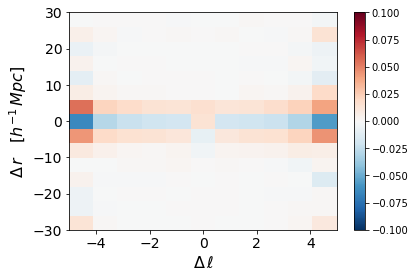

In [728]:
resid_plot(resid_data,vmax=0.1)

#### Look at matrix of residuals binned only over r

In [812]:
prec = True
matrix = leg_prec-np.linalg.inv(cf_legendre)
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/Legendre2PCF/radial_binning_cov.csv').mean(axis=1)

n=len(r_bins)
r_bins_all = np.concatenate([[r_bins[i] for _ in range(l_bins)] for i in range(len(r_bins))])
r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))

if prec:
    resid=matrix/r_matrix
else:
    resid=matrix*r_matrix

r_diff = []
for rr in r_bins:
    for rr2 in r_bins:
        r_diff.append(rr-rr2)
r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors

delta_r = r_diff[1]-r_diff[0]
r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)
    

In [813]:
output_vectors = np.zeros([l_bins,l_bins,len(r_diff)])
denom = np.zeros([l_bins,l_bins,len(r_diff)])
for i in range(len(resid)):
    l1_index = i%l_bins
    for j in range(resid.shape[1]):
        l2_index = j%l_bins
        r_index = np.where((r_bins_all[i]-r_bins_all[j]).round(3)==r_diff.round(3))
        output_vectors[l1_index,l2_index,r_index]=resid[i,j]
        denom[l1_index,l2_index,r_index]+=1
stack_resid = np.divide(output_vectors,denom)

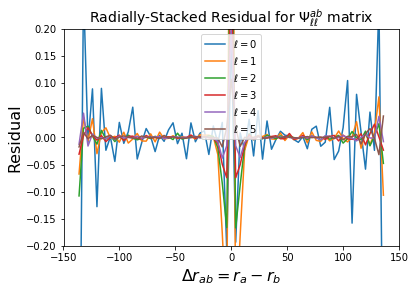

In [819]:
for i in range(l_bins):
    plt.plot(r_diff,stack_resid[i,i],label=r'$\ell = %d$'%i)
plt.legend();
plt.title(r'Radially-Stacked Residual for $\Psi_{\ell\ell}^{ab}$ matrix',fontsize=14)
plt.ylabel('Residual',fontsize=16);
plt.xlabel(r'$\Delta r_{ab} = r_a-r_b$',fontsize=16);
plt.ylim([-0.2,0.2]);

In [ ]:
def r_binned_residuals(matrix,prec=False):
    r_bins = np.loadtxt('/mnt/store1/oliverphilcox/Legendre2PCF/radial_binning_cov.csv').mean(axis=1)
    
    n=len(r_bins)
    r_bins_all = np.concatenate([[r_bins[i] for _ in range(l_bins)] for i in range(len(r_bins))])
    r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))
    
    if prec:
        resid=matrix/r_matrix
    else:
        resid=matrix*r_matrix
    
    r_diff = []
    for rr in r_bins:
        for rr2 in r_bins:
            r_diff.append(rr-rr2)
    r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors
    
    
    
    l_edge = np.linspace(-5,5,len(l_diff)+1)
    delta_r = r_diff[1]-r_diff[0]
    r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)
    l_edges = np.vstack([l_edge for _ in range(len(r_edge))])
    r_edges = np.vstack([r_edge for _ in range(len(l_edge))])

    stacked_resid = np.zeros([len(l_diff),len(r_diff)])
    denom = np.zeros([len(l_diff),len(r_diff)])
    for i in range(len(resid)):
        for j in range(resid.shape[1]):
            r_index = np.where((r_bins_all[i]-r_bins_all[j]).round(3)==r_diff.round(3))
            l_index = np.where((l_bins_all[i]-l_bins_all[j]).round(4)==l_diff.round(4))
            stacked_resid[l_index,r_index]=resid[i,j]
            denom[l_index,r_index]+=1
    stacked_resid=np.divide(stacked_resid,denom)
    return r_edges,l_edges,stacked_resid

def resid_plot(resid_data,vmax=0.5,title='',cbar_title="",FS=16,return_fig=False):
    r_edges,l_edges,stacked_resid=resid_data
    plt.pcolor(l_edges.T,r_edges,stacked_resid,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.ylim([-30,30]);
    plt.xlim([-5,5])
    cbar=plt.colorbar();FS=16
    plt.gca().xaxis.set_tick_params(which='both',labelsize=FS-2)
    plt.gca().yaxis.set_tick_params(which='both',labelsize=FS-2)
    if len(cbar_title)>0:
        cbar.set_label(cbar_title,fontsize=FS)
    plt.ylabel(r'$\Delta\,r \quad [h^{-1}\,Mpc]$',fontsize=FS);plt.xlabel(r'$\Delta\,\ell$',fontsize=FS);
    if len(title)>0:
        plt.title(title,fontsize=FS-2)
    if return_fig:
        return plt.gcf()

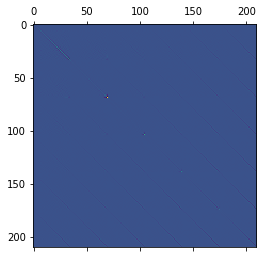

In [706]:
plt.matshow(rebinner(leg_prec-np.linalg.inv(cf_legendre)));

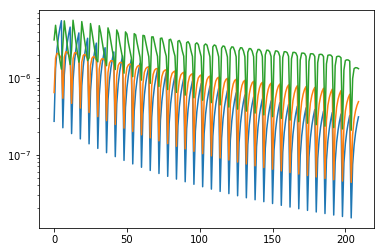

In [539]:
plt.plot(np.diag(c2l))
plt.plot(np.diag(c3l))
plt.plot(np.diag(c4l))
plt.yscale('log');